## Environment setup

### Library preparation

In [8]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

In [10]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

from qcodes.instrument_drivers.Keithley.Keithley_6220 import Keithley_6220

In [11]:
# #This code saves the image sources in clipboard into png file and copy a short PY code back into clipboard to display the specific png file. 

# import time, os
# dir_path = os.getcwd()
# pngpath = dir_path+"\\img\\{}{}{}-{}{}{}.png".format(time.localtime()[0]%100,time.localtime()[1],time.localtime()[2],time.localtime()[3],time.localtime()[4],time.localtime()[5])

# from PIL import ImageGrab
# img = ImageGrab.grabclipboard()
# img.save(pngpath, 'PNG')

# from IPython.display import Image, display
# display(Image(filename=pngpath))

# import clipboard
# clipboard.copy('display(Image(filename=r\'{}\'))'.format(pngpath))

In [12]:
# display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\measDC\55B1_revist 1D chain\img\19113-124446.png'))

### Instrument nicknames and QC database initialization

In [13]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = .1e-3
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
# Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.08s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.10s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


## Fridge handling log

In [7]:
# action = 'User: wsLu. Sample: {}. Roughing'.format(SAMPLE)
# action = 'ON Turbo @P1 = 6.47E-2'
# action = 'ON PT @P1 = 8.26E-4. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 3.51E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 1.89E-1'
# action = 'Start Pulse_PreCool @T8 = 11.56K'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [48, 3.7, 0.661, 0.030, 0.80]
# Tlst = ['dont care']
flow = '0.20'
stillOut = '0'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)

T8.get()

0.0431527

Fri Nov  22 13:05:00 2019
	Collect mixture and warm up
	T[1,2,5,6,8]:	[54.1, 3.86, 0.9, 0.96, 0.98]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 12:25:00 2019
	Start Condense_wLN2
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 10:55:00 2019
	Start Pulse_PreCool @T8 = 13K
	T[1,2,5,6,8]:	[55.9, 5.0, 7.1, 9.8, 13]
	Flow = 0.00, 	Still = 0%

Fri Nov  22 08:55:00 2019
	Start Pulse_PreCool @T8 = 11.56K
	T[1,2,5,6,8]:	[49.6, 4.3, 5.0, 6.5, 8.9]
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	ON PT @P1 = 2.30E-3. ON HS-STILL, HS-MC
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 21:20:00 2019
	ON Turbo @P1 = 3.0E-3
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%

Wed Nov  20 22:35:00 2019
	User: wsLu. Sample: Q1D074, SiOx002. Roughing
	T[1,2,5,6,8]:	['dont care']
	Flow = 0.00, 	Still = 0%



## Scripts

### Measurement scripts

In [14]:
def uduFF_list(amp1=240e-12, amp2=2000e-12, stp1=2e-12, stp2=80e-12):

    i_list_uf = np.linspace(0, amp1, round (amp1/stp1) + 1)
    i_list_uc = np.linspace(amp1, amp2, round ((amp2-amp1)/stp2) + 1)
    i_list = np.append(i_list_uf, i_list_uc)

    i_list_d = [np.linspace(amp2, amp1, round ((amp2-amp1)/stp2) + 1),
                np.linspace(amp1, 0, round (amp1/stp1) + 1),
                np.linspace(0, -1*amp1, round (amp1/stp1) + 1),
                np.linspace(-1*amp1, -1*amp2, round ((amp2-amp1)/stp2) + 1)]
    for lst in i_list_d:
        i_list = np.append(i_list, lst)

    i_list_ucn = np.linspace(-1*amp2, -1*amp1, round ((amp2-amp1)/stp2) + 1)
    i_list_ufn = np.linspace(-1*amp1, 0, round (amp1/stp1) + 1)
    i_list = np.append(i_list, i_list_ucn)
    i_list = np.append(i_list, i_list_ufn)

    return i_list

In [15]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [16]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'IVc @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [17]:
def Bperiod_meas (amp=1e-9, Gain=100, R_bias=1e9, Attn=1, B_list = [0]):

    meas = set_meas(Vmeter.V, Bfield, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    tB_list = tqdm_notebook(B_list)

    name_exp(sample = SAMPLE, exp_type = 'B periodicity @T={}K, Ib={}A'.format(si_format(T8.get()), si_format(amp, precision=0)))
    with meas.run() as datasaver:

        for B in tB_list:

            Bfield.set(B)
            time.sleep(0.5)
            Isrc.I.set( 1*amp)
            Vp = Vmeter.V.get()
            Isrc.I.set(-1*amp)
            Vn = Vmeter.V.get()
            delV = Vp-Vn
            volt = [( Bfield, B ), ( Vmeter.V, delV )]

            datasaver.add_result(*volt) 

    cleanup()
    return datasaver.run_id 

In [18]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [19]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break

                    res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

*What is the difference between IVc_ada and IVcB_ada?*

In [20]:
# adaptive step size with while loop
def IVc_ada(npts_B = 51, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

    maxI    = 300e-9
    step_ff = 0.2e-9
    step_f  =  10e-9
    step_c  =  50e-9
    
    thr = thr

    B_list = np.linspace(ZF, ZF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)

                for pm in [1, -1]:

                    i = 22.5*1e-3/R_bias

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)
                    
                    step = step_f
                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > thr ):
                            step = step_c
                        else:
                            if 122-9 < i < 135-9:
                                step = step_ff
                            elif -122e-9 < i < -113e-9:
                                step = step_ff 
                            else:
                                step = step_f
                            
                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [21]:
def meas_Voffset(i):
    V_off = 0
    N = 10
    Isrc.I.set(i)


    for j in range(N):
#         time.sleep(.1)
        V_off += Vmeter.V.get()
    return V_off/N

In [22]:
# _updated_ adaptive step size with while loop
def IVc_adaptive(Gain=100, R_bias=1e9, Attn=1, find_istep=None, keepgoing=None, 
                 direction ='pm', record_back = False):

    def write_data(i,  v):
            
            
            res = [( Isrc.I, i ), ( Vmeter.V, v  )]
            datasaver.add_result(*res)
            return i - I_off , V - V_off

    if find_istep is None:
        raise Exception('Pls define find_step function to set the rules of current increasing')

    if keepgoing is None:
        raise Exception('Pls define keepgoing function to set the while-loop condition')

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)
    
    I_off =  22.5e-3/R_bias*Attn

    N_back = 51
    
    dir_map = {'pm':[1,-1], 'p':[1], 'm':[-1] }
    sign = dir_map[direction]                             
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    name_exp(sample = SAMPLE, exp_type = 'IVC @T ={:2.1f}mK'.format(T8.get()/1e-3 ) ) 
    with meas.run() as datasaver:
        
        for pm in sign:   #to measure in + and - directions

            i = I_off
            V_off = meas_Voffset(i)
            V = V_off
#             print(V_off)
                
            while keepgoing(i, V):
                

                write_data(i - I_off,  V - V_off)

                step = find_istep(i,V, B = Bfield.get() )
                i += pm*step
                Isrc.I.set(i)
#                 time.sleep(0.1)
                V = Vmeter.V.get()

            for i in np.linspace(i, I_off, N_back):
                Isrc.I.set(i)
               
                if record_back:
#                     time.sleep(0.1)
                    V = Vmeter.V.get()
                    write_data(i - I_off,  V - V_off)
            
    return datasaver.run_id 

In [23]:
# # _updated_ adaptive step size with while loop
# def fast_IVc_adaptive(Gain=100, R_bias=1e9, Attn=1, find_istep=None, keepgoing=None,
#                       direction ='pm', record = None, datasaver = datasaver):

#     Is = []
#     Vs = []
    
#     def write_data(i,  v):
            
            
#             res = [( Isrc.I, i ), ( Vmeter.V, v  )]
#             datasaver.add_result(*res)
#             return i - I_off , V - V_off

#     if find_istep is None:
#         raise Exception('Pls define find_step function to set the rules of current increasing')

#     if keepgoing is None:
#         raise Exception('Pls define keepgoing function to set the while-loop condition')

#     Vmeter.set_Gain (Gain = Gain) 
#     Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)
    
#     I_off =  22.5e-3/R_bias*Attn

#     N_back = 51
    
#     dir_map = {'pm':[1,-1], 'p':[1], 'm':[-1] }
#     sign = dir_map[direction]                             
    
        
#     for pm in sign:   #to measure in + and - directions

#         i = I_off
#         V_off = meas_Voffset(i)
#         V = V_off

#         while keepgoing(i, V):
            
#             Is.append(i)
#             Vs.append(V)
            
#             if 'u' in record:
#                 write_data(i - I_off,  V - V_off)

#             step = find_istep(i,V, B = Bfield.get() )
#             i += pm*step
#             Isrc.I.set(i)
#             time.sleep(0.05)
#             V = Vmeter.V.get()


#         for i in np.linspace(i, I_off, N_back):
#             Isrc.I.set(i)

#             if 'd' in record:
#                 time.sleep(0.05)
#                 V = Vmeter.V.get()
#                 write_data(i - I_off,  V - V_off)

#     return Is, Vs 

In [24]:
def keepgoing(i, v):
    Imax = 250e-9
    if abs(i) < Imax:
        return True
    else:
        return False

In [25]:
def istep_4Isw_B(i, v, B):
    
    step_ff =   .2e-9
    step_f  =  5e-9
    step_c  =  20e-9
    

    V_th = 200e-6
        
    if abs(v) < V_th:
        step = step_f
    else:
        step = step_c

    return step

### Hystogram methods

In [26]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [27]:
# adaptive step size with while loop
def IVcB_ada(npts_B = 51, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):
    ZF =  0.004e-3
    FF =  0.224e-3
    dF =  0.250e-3
    midF = 0.154e-3

#     maxI = 40e-9
#     step_ff = 2e-12
#     step_f = 10e-12
#     step_c = 200e-12
#     maxI    = 300e-9
#     step_ff = 200e-12
#     step_f  = 200e-12
#     step_c  =   4e-9
    maxI    = 300e-9
    step_ff =   2e-9
    step_f  =   2e-9
    step_c  =  50e-9
    
    thr = thr

    B_list = np.linspace(ZF - 2.0*dF, ZF + 2.0*dF, npts_B)
    tB_list = tqdm_notebook(B_list)

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    for B in tB_list:
        meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

        name_exp(sample = SAMPLE, exp_type = 'Bscan IVC @T ={:2.1f}mK, B = {}A'.format(T8.get()/1e-3, si_format(B)) )  
        with meas.run() as datasaver:

                Bfield.set(B)


                
                for pm in [1, -1]:
                    if B < midF:
                        step = step_f
                    else:
                        step = step_ff

                    i = 22.5*1e-3/R_bias*Attn

                    Isrc.I.set(i)
                    time.sleep(1)
                    V_off = Vmeter.V.get()
                    V_ = V_off
                    time.sleep(1)

                    while abs(i) < maxI:

                        Isrc.I.set(i)
                        time.sleep(tfsstb)

                        V = Vmeter.V.get()
                        dV = V - V_
                        V_ = V

                        res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]

                        datasaver.add_result(*res) 

                        if (abs(dV) > thr)  or (abs(V - V_off) > thr ) : #
                            step = step_c

                        i += pm*step

    cleanup()
    return datasaver.run_id 

In [28]:
# # Use this code for T-dependent tasks
# # Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# # The LS370 htr driver was coded in meas_util.py instead of qcode  
 
# setT8_lst = [.100, .150, .200, .250, .300] 

# tolerT8 = 0.02
# chkrepeat = 20
# chkperiod_sec = 2

# Tnow_alllst = []
# timer_lst = []

# htr.HTRset('10mA')

# for setT8 in setT8_lst:
# #     htr.setpoint(setT8)
#     htr.Tset(setT8)
#     print('ramping T8 to {}K...'.format(si_format(setT8)))
#     if setT8 < 60e-3:
#         time.sleep(300)
#     else:
#         time.sleep(30)
#     Tnow_lst = []

#     t0 = time.time()
#     count_T = 0
#     while count_T < chkrepeat:
#         T_now = T8.get()
#         if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
#             count_T +=1
#             Tnow_lst.append(T_now)
#             time.sleep(chkperiod_sec)
#         elif count_T >= 1 :
#             count_T -=1
#     t1 = time.time()
    
#     timer_lst.append(t1-t0)
#     Tnow_alllst.append(Tnow_lst)

#     # insert here the repeatative work to be done at each T
#     hist_meas()

# # htr.setpoint(0.030)
# htr.Tset(0.030)

In [29]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9, T_str = 0):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
            
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
            with open('CH0 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(R_now), time.localtime())+'\n')
                fp.close
            with open('CH8 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(T_now), time.localtime())+'\n')
                fp.close

#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            if T_str == 300:
                time.sleep(54.5)
            else:
                time.sleep(0.05)

    cleanup()
    return datasaver.run_id 

### Data processing scripts

In [30]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [31]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
    return ({'title':title, 'alldata':alldata})

def DFMbyid(run_id: int):
    data = databyid(run_id)
    DTF = {data['alldata'][0][0]['name'] : pd.Series(data['alldata'][0][0]['data'], index = np.arange(len(data['alldata'][0][0]['data']))), 
           data['alldata'][0][1]['name'] : pd.Series(data['alldata'][0][1]['data'], index = np.arange(len(data['alldata'][0][0]['data'])))} 
    DTF = pd.DataFrame(DTF)
    return DTF

def dataread (filename, splitkw = '!DATASTR!'):
    with open(filename,'r') as file:
        rawtxt = file.read()
        splittxt = rawtxt.split(splitkw)    
    return(splittxt)

def filetoDFM (filename):
    datatxt = dataread(filename = filename)
    datastr = io.StringIO(datatxt[1])
    DataFM = pd.read_csv(datastr, sep = '\t')
    DataFM = DataFM.drop(DataFM.index[0])
    DataFM = DataFM.astype(float)
    return(DataFM, datatxt[0])

def pltMaxMin(lst, pMF = 1.1):
    pMin = lst.mean()-pMF*(lst.max()-lst.min())/2
    pMax = lst.mean()+pMF*(lst.max()-lst.min())/2
    pPos = (lst.mean()-lst.min())*pMF+lst.min()
    return(pMin,pMax,pPos)

def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [32]:
# # Quick visualization of the results

# qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format('70B1N7')
# initialise_database()
# f,ax=plt.subplots()

# label = ['a',
#          'b',
#          'v',
#          'meas on Nov 11th']

# for i,v in enumerate([105, 971,1092,1095]):
#     data = get_data_by_id(v)
#     Is = data[0][0]['data']
#     Vs = data[0][1]['data']
#     ax.plot(Is, Vs, '.', ls='-',label = '{}'.format(label[i]))

# ax.legend()

## Devices and measurement setups

### Device overview

- ID: Q1D079: large JJ chains with large EJ to study noise
 - N0: (1ab,2ab), $R_{RT, 2pb} = 24.3k\Omega$ 
 - N6: (3ab,4ab), $R_{RT, 2pb} = 2.15k\Omega$
 - N5: (6ab,7ba), $R_{RT, 2pb} = 27.1k\Omega$
 - N3: (8ab,9ab), $R_{RT, 2pb} = 520k\Omega$ (9a is broken)
 - N1: (11ab,12ab), $R_{RT, 2pb} = 290k\Omega$
 
- Instrumentation
 - $R_{G, 2pb}$ = OVFL on all devices
 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$

- Device scheme for Q1D079
 - Type: 1D chain with 16 SQUIDs or single SQUID (N1 & N6), pentagon capacitors with larger spacing to accomodate larger junction area design.
 - Shunting capacitor C0: No Pt yet.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation: 375 torr "wet" oxigen, 30min (by Plamen)

#### Junction parameters
- D079 site1: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [580.0, 23.30382]
 - [I_AB (nA), EJ (mK)] = [1.10331, 26.29969] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [1.56645, 593.45954]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [0.42821]
 - [Q, Beta, EJ/EC] = [722.7, 522278.1, 13.1]

- D079 site3: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [65.0, 14.87825]
 - [I_AB (nA), EJ (mK)] = [9.84493, 234.67416] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [10.3096, 90.17078]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [1.27914]
 - [Q, Beta, EJ/EC] = [241.9, 58531.2, 116.9]

- D079 site5: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [3.375, 13.54702]
 - [I_AB (nA), EJ (mK)] = [189.60606, 4519.6505] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [195.75, 4.74904]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [5.61354]
 - [Q, Beta, EJ/EC] = [55.1, 3039.1, 2251.5]

- D079 site6: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [4.3, 16.76434]
 - [I_AB (nA), EJ (mK)] = [148.81871, 3547.4001] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [190.06, 4.89122]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [4.97324]
 - [Q, Beta, EJ/EC] = [62.2, 3872.1, 1767.2]

- D079 site0: 
 - [RN_JJ (kohm), Rs_JJ (kohm-um^2)] = [3.0375, 11.50227]
 - [I_AB (nA), EJ (mK)] = [210.6734, 5021.83389] (converted to SQUID)
 - [C_JJQP (fF), EC (mK)] = [184.535, 5.03766]
 - [C0 (fF), EC0 (mK)] = [463.10944, 2.00735]
 - [Freq_plasma (GHz))] = [5.91719]
 - [Q, Beta, EJ/EC] = [52.3, 2735.2, 2501.7]

### Biasing scheme

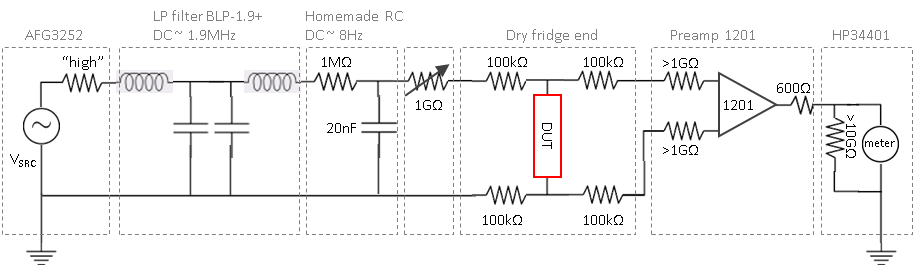

In [33]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

## Measurement

### List of run_ids

**pls update**

In [34]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

pd.set_option("display.precision", 3)

In [35]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

In [31]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [1],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [2],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [      range( 74,104+1),  43e-3, np.array([ZF])                      , np.nan, 'Ic stats'        ],
       [      range(105,107+1),  43e-3, np.array([ZF,midF,FF])              , np.nan, 'quick IVc vs B'  ],
       [      range(108,158+1),  50e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(159,209+1), 100e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(210,260+1), 150e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(261,311+1), 200e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(312,362+1), 250e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(363,413+1), 300e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(414,464+1), 350e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   1e-3, 'IVc vs B'        ],
       [      range(465,515+1), 400e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(516,566+1), 450e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(567,617+1), 500e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(618,668+1), 550e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(669,719+1), 600e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B'        ],
       [      range(763,813+1),  50e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(814,864+1), 150e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(865,915+1), 250e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [      range(916,966+1), 350e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [     range(967,1017+1), 450e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1018,1068+1), 550e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1069,1119+1), 650e-3, np.linspace(ZF, ZF + 1.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ],
       [    range(1234,1284+1),  50e-3, np.linspace(ZF, ZF + 2.0*dF, 51)    ,   3e-5, 'IVc vs B I_ff'   ]]
        
ex79N6 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

In [28]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [9],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                  [10],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N0 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

NameError: name 'ZF' is not defined

In [66]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [1],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [               [2,3,4],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N5 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

In [47]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [9],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N3 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████| 1/1 [00:00<00:00, 55.55it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████| 1/1 [00:00<00:00, 45.45it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|██████████████| 1/1 [00:00<00:00, 47.62it/s]


In [81]:
key = [                  'ids', 'T',    'B',                                  'Vthr', 'comments'        ]  
lst = [[                   [2],  16e+0, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [3],  65e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ],
       [                   [6],  43e-3, np.array([ZF])                      , np.nan, 'quick IVc meas'  ]]
        
ex79N1 = pd.DataFrame( data = list(zip(*lst)), columns = range(len(lst)), index = key ).transpose()

### Runs

In [43]:
IVC_udu (amp=300e-9, stp=4e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 1393



1393

<IPython.core.display.Javascript object>


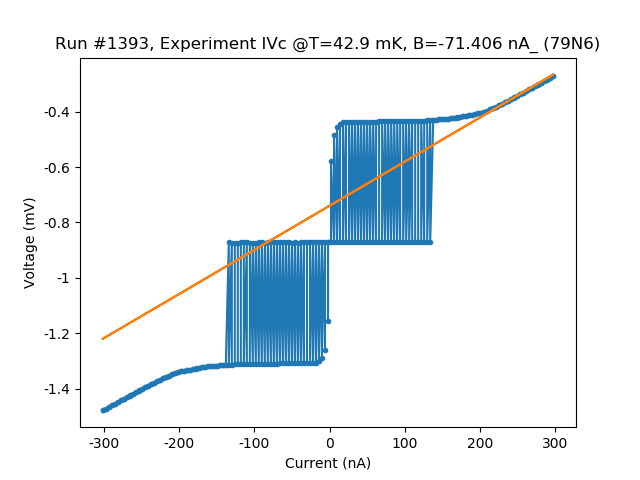

1590.348730974398 -0.0007398046371705848


In [40]:
fig, ax = plt.subplots()
plot_by_id(1393, axes = ax, marker = '.', ls ='-')

I, V = xy_by_id(1393)

idx = np.where(I>00e-9)

a,b = np.polyfit(I[idx], V[idx], 1)

print(a,b)

ax.plot(I, I*a + b)

<IPython.core.display.Javascript object>


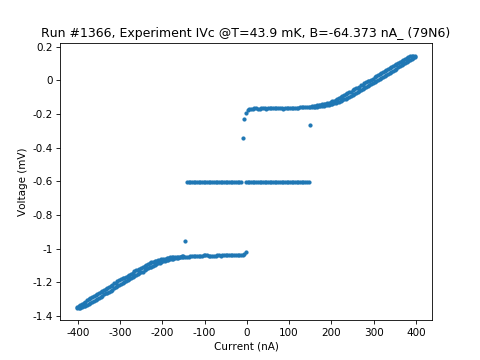

([<matplotlib.axes._subplots.AxesSubplot at 0xb15db50>], [None])

In [126]:
plot_by_id(1366, marker = '.', ls ='')

In [109]:
IVcB_ada(npts_B = 51, thr=250e-6, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 1315
Starting experimental run with id: 1316
Starting experimental run with id: 1317
Starting experimental run with id: 1318
Starting experimental run with id: 1319
Starting experimental run with id: 1320
Starting experimental run with id: 1321
Starting experimental run with id: 1322
Starting experimental run with id: 1323
Starting experimental run with id: 1324
Starting experimental run with id: 1325
Starting experimental run with id: 1326
Starting experimental run with id: 1327
Starting experimental run with id: 1328
Starting experimental run with id: 1329
Starting experimental run with id: 1330
Starting experimental run with id: 1331
Starting experimental run with id: 1332
Starting experimental run with id: 1333
Starting experimental run with id: 1334
Starting experimental run with id: 1335
Starting experimental run with id: 1336
Starting experimental run with id: 1337
Starting experimental run with id: 1338
Starting experimental run with id: 1339


1365

In [52]:
# B_list = np.linspace( 0, 0.500e-3, 501)
B_list = udu_list(amp=0.500e-3, stp=0.005e-3)
Bperiod_meas (amp=100e-9, Gain=100, R_bias=1e7, Attn=1, B_list = B_list)

Starting experimental run with id: 13



13

### Temp space for hist

In [72]:
Isrc.I.set(1e-9)

In [75]:
B = cos_to_B(.15)
Bfield.set(B)
IVC_udu (amp=20e-9, stp=.2e-9, Gain=100, R_bias=100.2e6, Attn=1, tfsstb = 0.1)
Bfield.set(0)

Starting experimental run with id: 1431



<IPython.core.display.Javascript object>


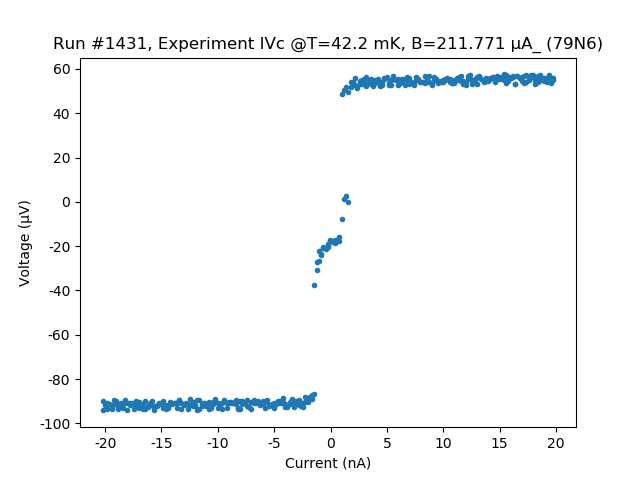

([<matplotlib.axes._subplots.AxesSubplot at 0xd5921f0>], [None])

In [76]:
plot_by_id(1431, marker = '.', ls = '')

In [50]:
B = cos_to_B(.25)
Bfield.set(B)
Isws =  meas_hist(1000)
save_hist(Isws)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


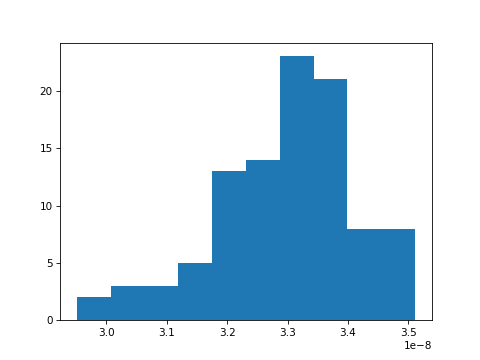

(array([ 2.,  3.,  3.,  5., 13., 14., 23., 21.,  8.,  8.]),
 array([2.95099919e-08, 3.00701213e-08, 3.06302507e-08, 3.11903801e-08,
        3.17505096e-08, 3.23106390e-08, 3.28707684e-08, 3.34308978e-08,
        3.39910273e-08, 3.45511567e-08, 3.51112861e-08]),
 <a list of 10 Patch objects>)

In [145]:
fig, ax = plt.subplots()
ax.hist(Isws)

In [32]:
meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

name_exp(sample = SAMPLE, exp_type = 'IVC for hist @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
with meas.run() as datasaver:

    Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_coarse, 
                               keepgoing =  if_Vth, direction = 'p', record = 'u')
    
print(Is)
print(extract_Isw (Is, Vs))


KeyboardInterrupt: 

In [31]:

# DEPRECATED

# def hist_meas():
#     meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

#     name_exp(sample = SAMPLE, exp_type = 'IVC for hist @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
#     with meas.run() as datasaver:

#         Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_coarse, 
#                                    keepgoing =  if_Vth, direction = 'p', record = 'u',
#                                    datasaver = datasaver)

#     coarse_Isw =  extract_Isw (Is, Vs)
#     print('Isw_coarse = {:2.0f} nA \n'.format(coarse_Isw /1e-9))

#     istep_4hyst = gen_istep_4hyst(0.8*coarse_Isw)


#     Isws = []
#     for j in tqdm_notebook(range(250)):
#         Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_4hyst,
#                              keepgoing =  if_Vth,  direction = 'p', record = 'None',
#                                   datasaver = None)

#         fine_Isw =  extract_Isw (Is, Vs)
#         Isws.append(fine_Isw)


#     counts, bins = np.histogram(Isws)     
#     N_try = qc.Parameter('try')    

#     meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)

#     name_exp(sample = SAMPLE, exp_type = 'Isw for Histogram dI = .2nA @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
#     with meas.run() as datasaver: 
#         for j, I in enumerate(Isws):
#             res = [ ( N_try, j  ) ,( Isrc.I, I ),]

#             datasaver.add_result(*res)   

<IPython.core.display.Javascript object>


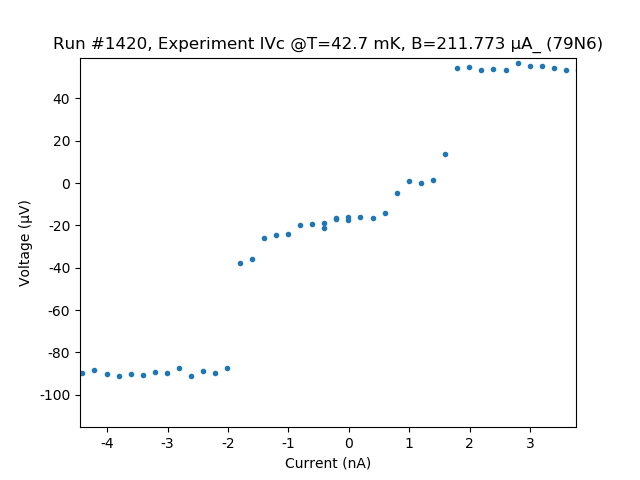

([<matplotlib.axes._subplots.AxesSubplot at 0xdd7df70>], [None])

In [64]:

plot_by_id(1420, marker = '.', ls = '')

In [58]:
for cos in [.2]:
    B = cos_to_B(cos)
    Bfield.set(B)
#     IVC_udu (amp=20e-9, stp=.2e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)
#     Bfield.set(B)
    Isws =  meas_hist(1000)
    save_hist(Isws, 'AWG, cos = {:1.2f}'.format(cos))
Bfield.set(0)


Starting experimental run with id: 1426
Run # 1426, AWG, cos = 0.20 @T =42.6mK saved


<IPython.core.display.Javascript object>


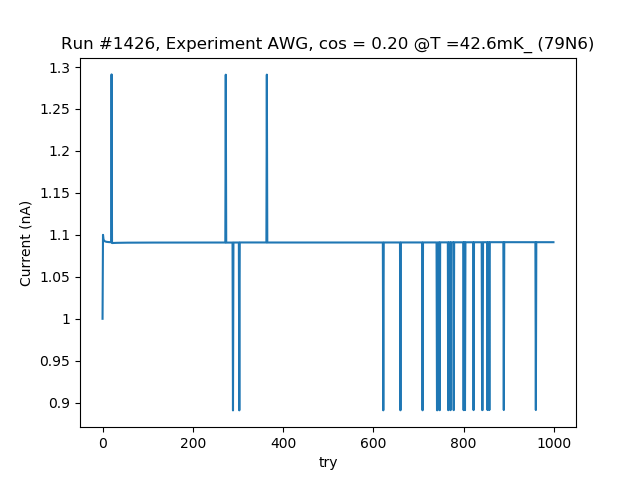

In [63]:
fig, ax = plt.subplots()
for idx in [1426]:
    plot_by_id(idx, axes = ax)
#     plot_hist_by_id(idx, ax = ax)
    

In [44]:

def cos_to_B(cos):
    FF_ = .232e-3
    ZF_ = .004e-3
    return np.arccos( cos)*(2* (FF_ - ZF_)/np.pi + ZF_  )

In [45]:
def plot_hist_by_id(idx, ax = None):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = True )
    return Isws

In [46]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [89]:
# Use this code for T-dependent tasks
# Using PID 30,5,1 & htr range 10mA for T8 upto 550mK
# The LS370 htr driver was coded in meas_util.py instead of qcode  
 
setT8_lst = [ .100, .150, .200, .300] 

tolerT8 = 0.02
chkrepeat = 20
chkperiod_sec = 2

Tnow_alllst = []
timer_lst = []

htr.HTRset('10mA')

for setT8 in setT8_lst:
#     htr.setpoint(setT8)
    htr.Tset(setT8)
    print('ramping T8 to {}K...'.format(si_format(setT8)))
    if setT8 < 60e-3:
        time.sleep(300)
    else:
        time.sleep(30)
    Tnow_lst = []

    t0 = time.time()
    count_T = 0
    while count_T < chkrepeat:
        T_now = T8.get()
        if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
            count_T +=1
            Tnow_lst.append(T_now)
            time.sleep(chkperiod_sec)
        elif count_T >= 1 :
            count_T -=1
    t1 = time.time()
    
    timer_lst.append(t1-t0)
    Tnow_alllst.append(Tnow_lst)

    # insert here the repeatative work to be done at each T
    for cos in [1, 0.7, 0.3]:
        B = cos_to_B(cos)
        Bfield.set(B)
        Isws =  meas_hist(1000)
        save_hist(Isws, 'AWG cos = {:1.2f}'.format(cos))
    

# htr.setpoint(0.030)
htr.Tset(0.030)

ramping T8 to 100.0 mK...


ValueError: ('3.573015668529256e-07 is invalid: must be between -3.5714285714285716e-07 and 3.5714285714285716e-07 inclusive; Parameter: gen.I', 'setting gen_I to 3.573015668529256e-07')

In [39]:
Vmeter.init('fast 4')
IVC_udu (amp=300e-9, stp=4e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

Starting experimental run with id: 1231



1231

In [47]:
def meas_hist(N, t_offset = 0):

    Isws = []

    i = 0
    istep = .2e-9
    i0 = 2e-9

    Isrc.I.set(i0)
    time.sleep(1)
    Isrc.I.set(-i0)
    time.sleep(1)
    V_off = meas_Voffset(0)

    t0 = time.time()    
    for n in tqdm_notebook(range(N)):

#         print(1e3*(time.time()-t0))
        V = V_off

        while (V - V_off) < 50e-6:
            
            i += istep
            time.sleep(t_offset)
            Isrc.I.set(i)
            V = Vmeter.V.get()
            
        Isws.append(i)
#         print(i)

        Isrc.I.set(-i0)
        time.sleep(1)
        i = np.mean(Isws)*-.1
#         Isrc.I.set(i)
        time.sleep(0.1)

    return Isws

In [37]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(Vmeter.__dict__)

{   'V_to_Vdut': <function HP34401_DL1201.__init__.<locals>.<lambda> at 0x0A674DF8>,
    '_Gain': 100,
    '_address': 'GPIB0::8::INSTR',
    '_meta_attrs': ['name'],
    '_t0': 1576430919.2558923,
    '_terminator': '',
    'functions': {},
    'log': <InstrumentLoggerAdapter qcodes.instrument.base (WARNING)>,
    'metadata': {},
    'name': 'meter',
    'parameters': {   'IDN': <qcodes.instrument.parameter.Parameter: IDN at 174569392>,
                      'V': <qcodes.instrument.parameter.Parameter: V at 174570032>,
                      'Vraw': <qcodes.instrument.parameter.Parameter: Vraw at 174570416>,
                      'timeout': <qcodes.instrument.parameter.Parameter: timeout at 174569872>},
    'short_name': 'meter',
    'submodules': {},
    'visa_handle': <'GPIBInstrument'('GPIB0::8::INSTR')>,
    'visa_log': <InstrumentLoggerAdapter qcodes.instrument.base.com.visa (WARNING)>,
    'visabackend': 'ni',
    'visalib': None}


### Plans and list of ToDo-es
- Read hist and clean up the codes
- Better htr coding control protocol

**Selected meas to be done**
- Careful IVc_B scan (maybe we can get that from hist already)
- Compare IVc(delay 0.1 vs 0.5)
- Compare hist(6221 vs AWG)

check delay between source and DUT input

check how hisogram depends on
  -  scanning speed (est ramping rate)
  -  current direction
  -  filtering
  -  leads floating
  
for the best setup:
    - B scan (base T, for cos = 1, 0.6, 0.3)
    - T scan (T = 100, 150, 200, 300, 400, 500)

In [127]:
Isrc.close()
Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
Vmeter.init('fast 4')
save_hist(meas_hist(10), 'KE cos = 1 at 45mK') #6.14 it/s, 1:01min ttl; id: 1397

38.00201416015625
6735.385179519653
12881.736516952515
18837.077379226685
24867.422342300415
30922.768592834473
36905.11059761047
43047.46198654175
49106.80866241455
55200.157165527344

Starting experimental run with id: 1397
Run # 1397, KE cos = 1 at 45mK @T =45.7mK saved


In [128]:
Isrc.close()
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 11.2e6, Attn = 1)
Vmeter.init('fast 4')
save_hist(meas_hist(10), 'AWG cos = 1 at 45mK') #23.4 it/s, 3:36min ttl; id: 1398

29.001474380493164
24270.38812637329
45664.61181640625
67694.87166404724
89292.10710525513
105356.02569580078
127688.303232193
149784.56687927246
172084.84268188477
194679.13484573364

Starting experimental run with id: 1398
Run # 1398, AWG cos = 1 at 45mK @T =45.1mK saved


In [51]:
Isrc.close()
Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
Vmeter.init('fast 4')
save_hist(meas_hist(10), 'KE cos = 1 at 45mK') #23.2 it/s, 3:52min ttl; id: 1399

42.00243949890137
24003.37314605713
47489.71629142761
70166.01324081421
93733.36148262024
115563.60983848572
138589.9269580841
161734.2507839203
184860.57353019714
208380.9187412262

Starting experimental run with id: 1399
Run # 1399, KE cos = 1 at 45mK @T =42.7mK saved


In [62]:
Isrc.close()
Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 11.2e6, Attn = 1)
Vmeter.init('fast 4')
for t in range(0,35,5):
    save_hist(meas_hist(N=100,t_offset = t/(150e-9*.9/.2e-9)), 'AWG delay {}s/it'.format(t))

37.0020866394043
24647.409677505493
46912.68301010132
68607.92398452759
90470.17455101013
112903.45764160156
134928.71737480164
157240.99373817444
178572.21364974976
200503.4680366516
221601.67479515076
243567.93117523193
265129.16469573975
287393.4381008148
309292.6905155182
331359.95268821716
353421.2145805359
375551.4805316925
397418.73121261597
419777.00996398926
442273.29683303833
464237.5531196594
486134.8054409027
508367.0768737793
530164.3238067627
551836.5633487701
573855.82280159
596259.104013443
618285.3639125824
640844.654083252
663096.9271659851
684929.1756153107
707293.4548854828
728760.6828212738
750656.9349765778
772250.1702308655
793983.4134578705
816251.6870498657
838510.9603404999
860975.2449989319
883205.516576767
904235.719203949
926499.9928474426
948197.2336769104
970492.5091266632
992527.7695655823
1014591.0313129425
1036787.300825119
1058918.5667037964
1081214.84208107
1103279.103755951
1125378.368139267
1147179.6147823334
1169640.8996582031
1191500.1499652863
1

39.002418518066406
29666.697025299072
56886.25383377075
84262.81976699829
111284.36517715454
138839.94150161743
166169.50464248657
192590.01564979553
219725.567817688
245590.04712104797
272920.61042785645
299939.1555786133
326966.70174598694
352896.18468284607
380277.7509689331
406846.27056121826
434069.8275566101
461687.40725517273
488117.9189682007
515510.4856491089
542645.037651062
569823.5921859741
596770.1332569122
623823.6808776855
651081.239938736
678545.8106994629
705654.3612480164
732366.888999939
759283.4286689758
785493.9277172089
812790.4891967773
839241.0020828247
866534.5630645752
893716.1178588867
921283.6947441101
948921.2753772736
976436.849117279
1003635.4048252106
1030462.9392623901
1057163.4662151337
1084559.0333938599
1111692.5852298737
1138740.1323318481
1165790.679693222
1192929.2318820953
1220314.798116684
1247538.3553504944
1275135.9338760376
1301699.4533538818
1329230.0279140472
1355833.5492610931
1382374.0675449371
1408972.5885391235
1436105.1404476166
146322

41.002511978149414
35987.05840110779
67267.8472995758
99680.70149421692
131774.53708648682
163620.35870552063
195852.20193862915
227433.0084323883
259934.86738204956
291855.6933403015
323869.5242404938
355816.3514137268
388180.20272254944
420111.0289096832
451470.82257270813
483383.6479187012
515650.4936218262
548060.3473186493
579714.1578197479
611484.9750995636
642948.7745761871
674412.5740528107
706842.4291610718
739388.2904052734
771544.1298484802
803010.9295845032
834623.7378120422
866371.5536594391
898398.3852863312
930515.2225494385
962073.0276107788
994489.8815155029
1025360.6474399567
1057965.5120372772
1089724.3287563324
1120825.107574463
1152968.9462184906
1185049.780845642
1217179.6188354492
1249159.447669983
1281120.2759742737
1312434.066772461
1344864.9218082428
1377199.7714042664
1408956.5877914429
1441273.4360694885
1472806.23960495
1504961.0786437988
1536963.9093875885
1568575.7172107697
1600746.5574741364
1633247.4164962769
1664289.1919612885
1696579.0386199951
172720

40.00234603881836
39270.246267318726
75398.31256866455
111793.3943271637
147958.46271514893
183237.4804019928
218756.51216506958
255913.63739967346
291771.6884613037
329054.8210144043
364440.8447742462
401702.97598838806
437916.047334671
473195.0650215149
508791.1012172699
545339.1916751862
582503.3173561096
618331.3665390015
655620.4991340637
691754.566192627
727844.630241394
764577.7313709259
800342.7767753601
835386.7814540863
872047.8782653809
908834.9823951721
945286.0672473907
979742.0380115509
1016618.1471347809
1052622.2064495087
1089178.2972812653
1124218.3015346527
1160500.3769397736
1196414.4310951233
1233010.5242729187
1270166.6493415833
1306782.743692398
1342662.7957820892
1378608.8516712189
1414898.9276885986
1450628.9710998535
1487882.1020126343
1524070.1715946198
1560681.2660694122
1597894.394159317
1634922.512292862
1671956.63022995
1708279.7079086304
1744591.7847156525
1781771.9113826752
1816101.8750667572
1852394.9508666992
1888713.0281925201
1925271.1191177368
19620

33.00166130065918
45719.61498260498
86020.92003822327
125706.18987083435
165003.4375190735
206599.81656074524
247818.17412376404
289123.53682518005
330257.88950920105
370003.16286087036
411082.5123786926
452485.8808517456
493219.21038627625
533273.5013961792
574757.874250412
616621.2687492371
656468.5478210449
696642.8456306458
737685.1933002472
778614.5341396332
819355.8642864227
859788.1767749786
901356.5545082092
942827.9263973236
983195.235490799
1023782.5570106506
1064002.8574466705
1104574.177980423
1144453.4590244293
1184864.7701740265
1225184.0765476227
1265445.3792572021
1306800.7447719574
1347612.0791435242
1388758.4323883057
1429553.7657737732
1470412.1026992798
1510628.4029483795
1552070.7731246948
1593466.140985489
1633280.4181575775
1673280.7059288025
1714184.045791626
1754976.378917694
1795349.688053131
1833371.8626499176
1874529.217004776
1915059.5350265503
1955222.83244133
1996601.1991500854
2037579.5426368713
2078057.857990265
2119136.2075805664
2160347.5646972656
220

40.00234603881836
50161.869049072266
94212.38851547241
139821.99716567993
184428.54857444763
229259.11283493042
275063.73262405396
320744.34542655945
365855.92579841614
410755.49387931824
455768.06831359863
500489.6264076233
544130.122423172
590110.7523441315
635610.3546619415
678149.787902832
723678.3919334412
769042.9866313934
814669.5964336395
860892.2400474548
906379.842042923
951221.4066982269
996868.0176734924
1042474.6260643005
1088507.2588920593
1133816.8506622314
1179656.4724445343
1225903.1174182892
1271453.7227153778
1315537.2443199158
1360285.8037948608
1406598.4525680542
1451513.0217075348
1496059.5695972443
1541597.174167633
1587889.8222446442
1631967.3430919647
1678305.9933185577
1724815.6538009644
1769567.2132968903
1814919.807434082
1859840.3768539429
1903944.8993206024
1948935.4724884033
1994558.0823421478
2040492.7093982697
2086519.3419456482
2132974.999189377
2178492.602586746
2224730.2470207214
2271256.908416748
2317376.5461444855
2362916.151046753
2407485.70036888

39.002180099487305
54658.12611579895
104048.9513874054
154481.83584213257
204621.70362472534
253537.50157356262
303806.37669563293
352861.18245124817
401300.95314979553
450941.79224967957
500350.61836242676
550061.461687088
599664.2987728119
649741.1630153656
699491.0085201263
750141.9057846069
800930.8106899261
850678.6561012268
899928.4727573395
950715.3778076172
1001273.2696533203
1050719.0976142883
1100481.943845749
1151079.8380374908
1201587.7268314362
1250702.535867691
1300862.4048233032
1350482.2430610657
1399160.0275039673
1449020.8790302277
1498487.708568573
1549261.6126537323
1599435.4825019836
1648747.3030090332
1698591.1536216736
1747634.9589824677
1796012.7260684967
1846206.5968513489
1894825.3779411316
1945634.2837810516
1995405.1306247711
2045481.9948673248
2095240.8409118652
2145491.715192795
2193631.4685344696
2243176.302433014
2292965.1498794556
2343131.0193538666
2393724.91312027
2444050.7917404175
2494244.6625232697
2544105.514526367
2594654.405593872
2644218.240499

<IPython.core.display.Javascript object>


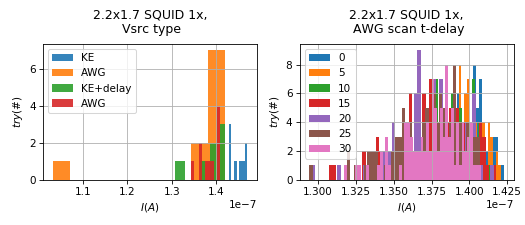

[1.46400000e-07 1.45840000e-07 1.41012000e-07 1.42841733e-07
 1.43202343e-07 1.41185922e-07 1.45541367e-07 1.43371762e-07
 1.44167439e-07 1.46972917e-07]
[1.38600000e-07 1.35260000e-07 1.38893000e-07 1.36358433e-07
 1.03127786e-07 1.40044784e-07 1.38804733e-07 1.40101268e-07
 1.41989875e-07 1.39279776e-07]
[1.30800000e-07 1.41080000e-07 1.36994000e-07 1.42029133e-07
 1.32372578e-07 1.39065514e-07 1.39905687e-07 1.39546384e-07
 1.41772416e-07 1.40617397e-07]
[1.40800000e-07 1.40480000e-07 1.40464000e-07 1.34258133e-07
 1.36500053e-07 1.39050044e-07 1.38459204e-07 1.37657306e-07
 1.36445859e-07 1.40423496e-07]


In [68]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['KE', 'AWG', 'KE+delay', 'AWG','','']
for i,v in enumerate([1397,1398, 1399, 1400]):#fast 4, fast
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    print(Ic)
    ax[0].hist(Ic, bins=10, label = label[i], alpha = 0.9)

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc type', pad=10)
ax[0].grid()
ax[0].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label =  range(0,35,5)
for i,v in enumerate(range(1408,1414+1)):#fast 4, fast 1401,1407+1
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
#     print(Ic)
#     ax[0].plot(Ic,np.linspace(0,9,10))
    ax[1].hist(Ic, bins=50, label = label[i], alpha = 1)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n AWG scan t-delay', pad=10)
# ax[1].set_ylim(0,5)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [82]:
Bfield.set(cos_to_B(0.30))
htr.HTRset('10mA')
htr.Tset(0.1)

'setpoint changed to 100.0 mK'

In [84]:
l = meas_hist(1000)
save_hist(l, 'AWG cos = {:1.2f} at 100mK'.format(0.3)) # 1396, AWG cos = 0.30 at 100mK @T =100.1mK saved

KeyboardInterrupt: 

In [100]:
Bfield.set(ZF)
htr.Tset(0.03)

'setpoint changed to 30.0 mK'

<IPython.core.display.Javascript object>


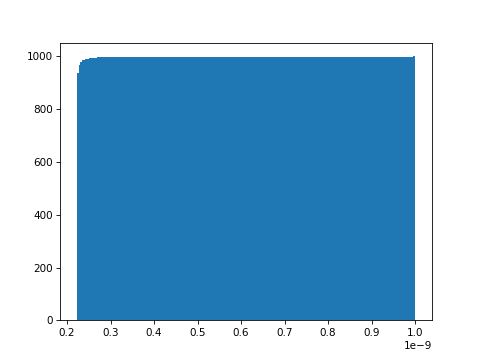

array([1.00000000e-09, 9.00000000e-10, 6.95000000e-10, 2.86500000e-10,
       2.72037500e-10, 2.63070750e-10, 2.56943471e-10, 2.52479310e-10,
       2.49075388e-10, 2.46390071e-10, 2.44214965e-10, 2.42415559e-10,
       2.40901058e-10, 2.39607908e-10, 2.38490257e-10, 2.37514175e-10,
       2.36654003e-10, 2.35889967e-10, 2.35206580e-10, 2.34591531e-10,
       2.34034912e-10, 2.33528654e-10, 2.33066118e-10, 2.32641792e-10,
       2.32251058e-10, 2.31890020e-10, 2.31555366e-10, 2.31244261e-10,
       2.30954267e-10, 2.30683272e-10, 2.30429441e-10, 2.30191167e-10,
       2.29967040e-10, 2.29755818e-10, 2.29556399e-10, 2.29367806e-10,
       2.29189166e-10, 2.29019700e-10, 2.28858707e-10, 2.28705558e-10,
       2.28559683e-10, 2.28420568e-10, 2.28287746e-10, 2.28160793e-10,
       2.28039322e-10, 2.27922980e-10, 2.27811444e-10, 2.27704416e-10,
       2.27601625e-10, 2.27502820e-10, 2.27407769e-10, 2.27316259e-10,
       2.27228093e-10, 2.27143088e-10, 2.27061073e-10, 2.26981892e-10,
      

In [83]:
plot_hist_by_id(1396)

<IPython.core.display.Javascript object>


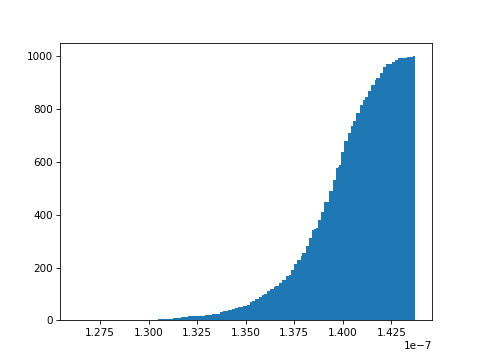

array([1.36200000e-07, 1.42420000e-07, 1.39531000e-07, 1.39538367e-07,
       1.39142234e-07, 1.36536632e-07, 1.41089471e-07, 1.41920824e-07,
       1.37554732e-07, 1.37332592e-07, 1.38912659e-07, 1.37110714e-07,
       1.40894077e-07, 1.39709102e-07, 1.40713517e-07, 1.39724039e-07,
       1.40327062e-07, 1.38133277e-07, 1.39926613e-07, 1.39530089e-07,
       1.30731235e-07, 1.38690373e-07, 1.42089403e-07, 1.37103296e-07,
       1.40495255e-07, 1.39901426e-07, 1.40104838e-07, 1.39708751e-07,
       1.42110970e-07, 1.39721319e-07, 1.40123013e-07, 1.39925893e-07,
       1.39127977e-07, 1.40927517e-07, 1.37132377e-07, 1.41726116e-07,
       1.39332963e-07, 1.40532972e-07, 1.41536139e-07, 1.33941715e-07,
       1.39128026e-07, 1.39727655e-07, 1.37928729e-07, 1.36525570e-07,
       1.39319365e-07, 1.43719644e-07, 1.40729477e-07, 1.37932530e-07,
       1.38729628e-07, 1.39728472e-07, 1.38529359e-07, 1.33927861e-07,
       1.40117571e-07, 1.39319348e-07, 1.39319581e-07, 1.38919806e-07,
      

In [75]:
plot_hist_by_id(1394)

check delay between source and DUT input

check how hisogram depends on
  -  scanning speed (est ramping rate)
  -  current direction
  -  filtering
  -  leads floating
  
for the best setup:
    - B scan (base T, for cos = 1, 0.6, 0.3)
    - T scan (T = 100, 150, 200, 300, 400, 500)

<IPython.core.display.Javascript object>


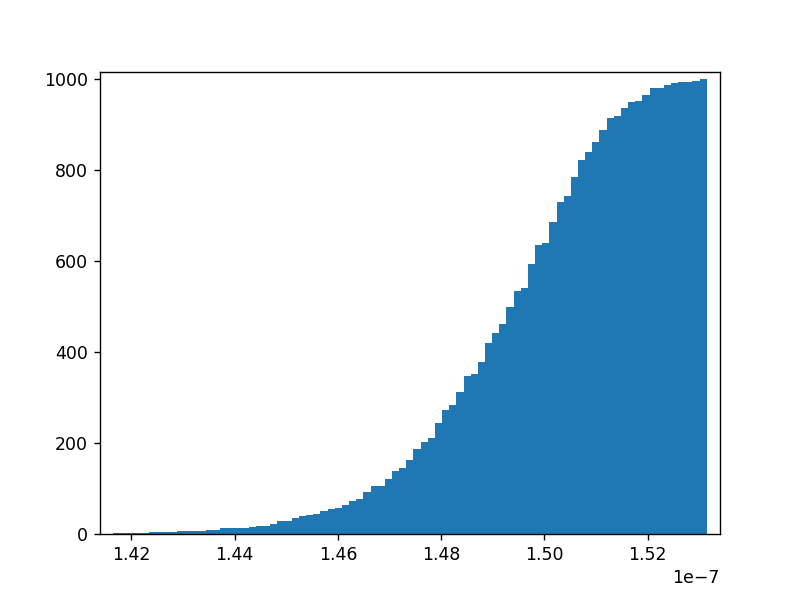

Starting experimental run with id: 1226


In [273]:
fig, ax = plt.subplots()
ax.hist(Isws, bins = 201, cumulative = True )
save_hist(Isws)

In [274]:
np.std(Isws)

1.9762474430539192e-09

<IPython.core.display.Javascript object>


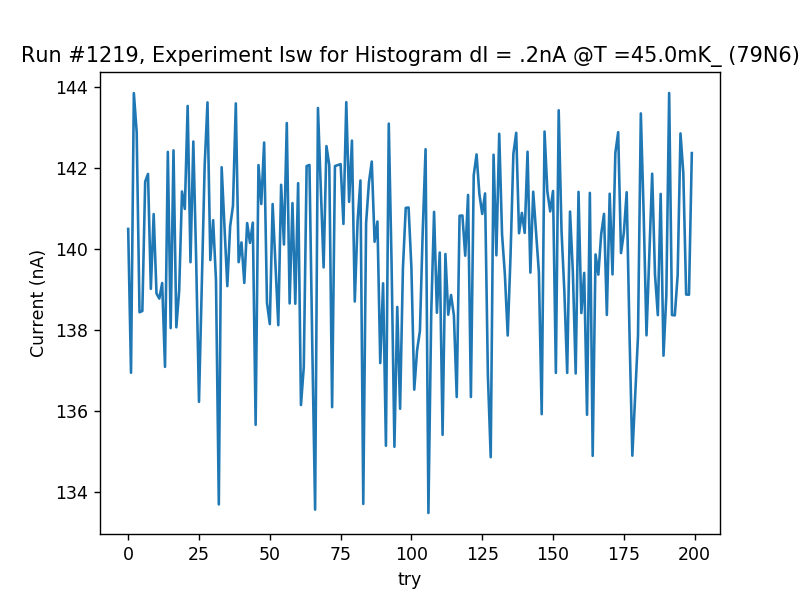

([<matplotlib.axes._subplots.AxesSubplot at 0x1ccbfa90>], [None])

In [216]:
plot_by_id(1219)

In [181]:
for i in tqdm_notebook(range(100)):
    Vmeter.V.get()

### Results

#### $2.2 \times 1.7 \mu m$   chain (N0) / Single SQUID (N6) / chain (N5) with $E_J = 2K$

<IPython.core.display.Javascript object>


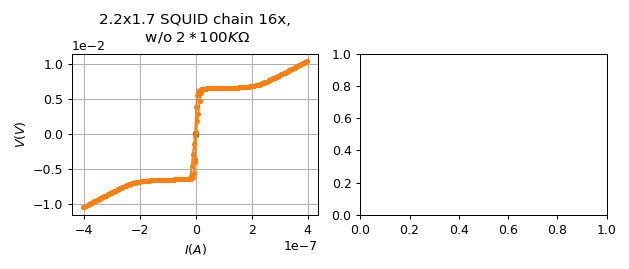

In [99]:
SAMPLE = '79N0' #1ab,2ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate([9,10]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID chain 16x,\n w/o $2* 100K\Omega$', pad=10)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


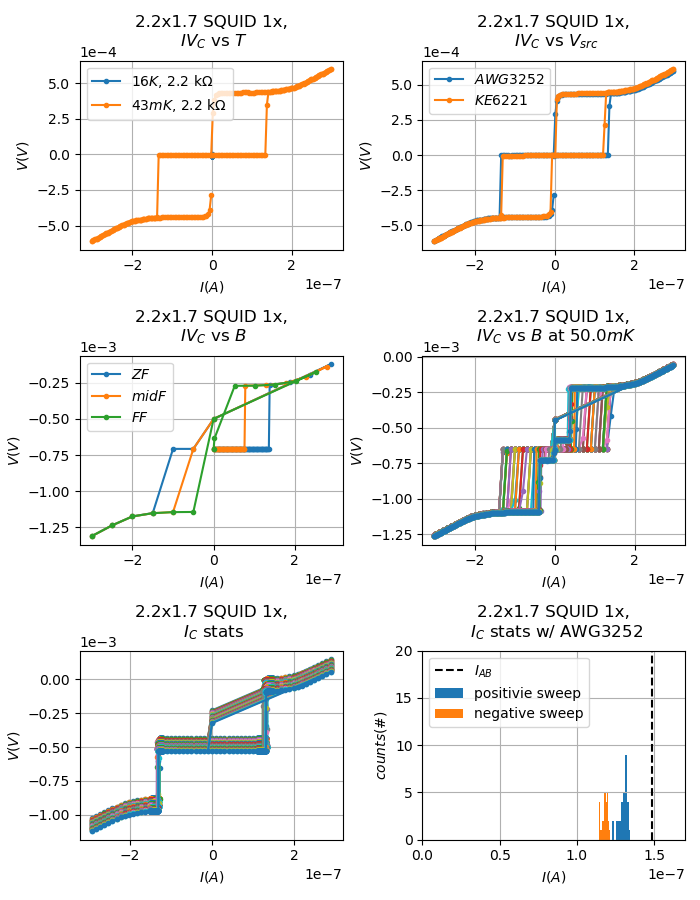

In [213]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(3,2, figsize=(7,9))
# ax.flatten()

labelL = ['$16K$' ,
          '$43mK$']
for i,v in enumerate([1,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0,0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))
ax[0,0].set_xlabel('$I (A)$')
ax[0,0].set_ylabel('$V (V)$')
ax[0,0].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $T$', pad=10)
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelL1 = ['$AWG3252$',
          '$KE6221$']
for i,v in enumerate([4,9]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[0,1].plot(Is, Vs, '.', ls='-',label = labelL1[i])
ax[0,1].set_xlabel('$I (A)$')
ax[0,1].set_ylabel('$V (V)$')
ax[0,1].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $V_{src}$', pad=10)
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

labelR = ['$ZF$'  ,
          '$midF$',
          '$FF$'   ]
for i,v in enumerate([105,106,107]):#
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1,0].plot(Is, Vs, '.', ls='-',label = labelR[i])
ax[1,0].set_xlabel('$I (A)$')
ax[1,0].set_ylabel('$V (V)$')
ax[1,0].set_title('2.2x1.7 SQUID 1x,\n $IV_{C}$ vs $B$', pad=10)
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

T = 50e-3
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1,1].plot(Is, Vs, '.', ls='-')
ax[1,1].set_xlabel('$I (A)$')
ax[1,1].set_ylabel('$V (V)$')
ax[1,1].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)
ax[1,1].grid()
ax[1,1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

for i,v in enumerate(range(74,104+1)):#56,
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']#-data[0][1]['data'][0]
    ax[2,0].plot(Is, Vs, '.', ls='-')
ax[2,0].set_xlabel('$I (A)$')
ax[2,0].set_ylabel('$V (V)$')
ax[2,0].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats', pad=10)
ax[2,0].grid()
ax[2,0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Iclstp = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[:int(len(np.diff(Vs))/2)-30]):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
Iclstn = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[int(len(np.diff(Vs))/2)+30:]):
        if abs(w) > 1e-4:
            Iclstn = np.append(Iclstn,np.abs(Is[j]))
            break
ax[2,1].plot(np.full(len(range(0,100)),148.8e-9),range(0,100),'--', label = '$I_{AB}$', color = 'black')
ax[2,1].hist(Iclstp, label = 'positivie sweep')
ax[2,1].hist(Iclstn, label = 'negative sweep')

ax[2,1].set_xlim(0,170e-9)
ax[2,1].set_ylim(0,20)
ax[2,1].set_xlabel('$I (A)$')
ax[2,1].set_ylabel('$counts (\#)$')
ax[2,1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252', pad=10)
ax[2,1].legend()
ax[2,1].grid()

plt.tight_layout()

In [ ]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(2,1, figsize=(4,6))
ax = ax.flatten()

Iclstp = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[:int(len(np.diff(Vs))/2)-30]):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
Iclstn = np.asarray([])
for i,v in enumerate(range(74,104+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)[int(len(np.diff(Vs))/2)+30:]):
        if abs(w) > 1e-4:
            Iclstn = np.append(Iclstn,np.abs(Is[j]))
            break
ax[0].plot(np.full(len(range(0,1000)),148.8e-9),range(0,1000),'--', label = '$I_{AB}; 35mK$', color = 'black')
ax[0].hist(Iclstp, label = 'pos. swp')
ax[0].hist(Iclstn, label = 'neg. swp')
ax[0].set_xlim(0,170e-9)
ax[0].set_ylim(0,20)
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$counts (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252, 12/11', pad=10)
ax[0].legend()
ax[0].grid()

label = ['150mK', '200mK', '250mK', '300mK']
for i,v in enumerate([1204,1206,1208,1210]):#56,
    data = get_data_by_id(v)
    Ic = data[0][1]['data']#-data[0][1]['data'][0]
    ax[1].hist(Ic, label = label[i])
ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_xlim(0,170e-9)
ax[1].set_ylim(0,200)
ax[1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ stats w/ AWG3252, 12/12', pad=10)
ax[1].grid()
ax[1].legend()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
plot_by_id(1367, axes = ax, marker = '.', ls ='')

I, V = xy_by_id(1367)

idx = np.where(I>300e-9)

a,b = np.polyfit(I[idx], V[idx], 1)

print(a,b)

ax.plot(I, I*a + b)

<IPython.core.display.Javascript object>


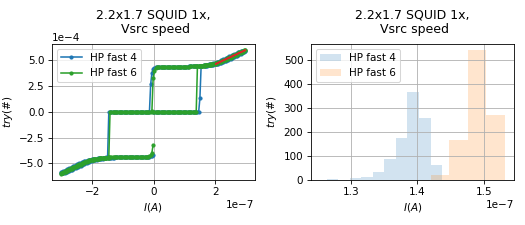

1316.4548076923065 0.00019994785213770693
1387.247701923077 0.00018438447145942703


In [101]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['HP fast 4', 'HP fast 6']
for i,v in enumerate([1229,1231]):#fast 4, fast 6
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    ax[0].plot(Is,Vs,'.',ls='-', label = label[i])
    fitid = np.where(Is>200e-9)
    a,b = np.polyfit(Is[fitid], Vs[fitid], 1)
    print(a,b)

    ax[0].plot(Is[fitid], Is[fitid]*a + b)
    
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc speed', pad=10)
ax[0].grid()
ax[0].legend()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label = ['HP fast 4', 'HP fast 6']
for i,v in enumerate([1394,1226]):#fast 4, fast 6
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    ax[1].hist(Ic, label = label[i], alpha = 0.2)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n Vsrc speed', pad=10)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


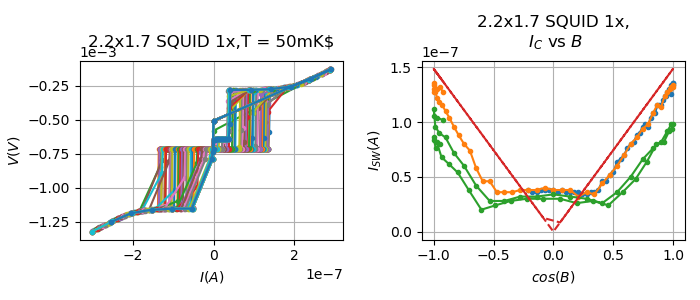

In [77]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate(range(763,813+1)):#763,813+1
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-')
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID 1x,T = 50mK$', pad=10)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 1.0*dF, 51)
for i,v in enumerate(range(763,813+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 2.0*dF, 51)
for i,v in enumerate(range(1234,1284+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
Iclstp = np.asarray([])
Blst = np.linspace(ZF - 2.0*dF, ZF + 2.0*dF, 51)
for i,v in enumerate(range(1315,1365+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-')
ax[1].plot(np.cos(Blst/FF*np.pi/2),148.8e-9*np.abs(np.cos(Blst/FF*np.pi/2)),'--', label = '$I_{AB}*cos(B)$')
ax[1].set_xlabel('$cos(B)$')
ax[1].set_ylabel('$I_{SW} (A)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n $I_C$ vs $B$', pad=10)
# ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


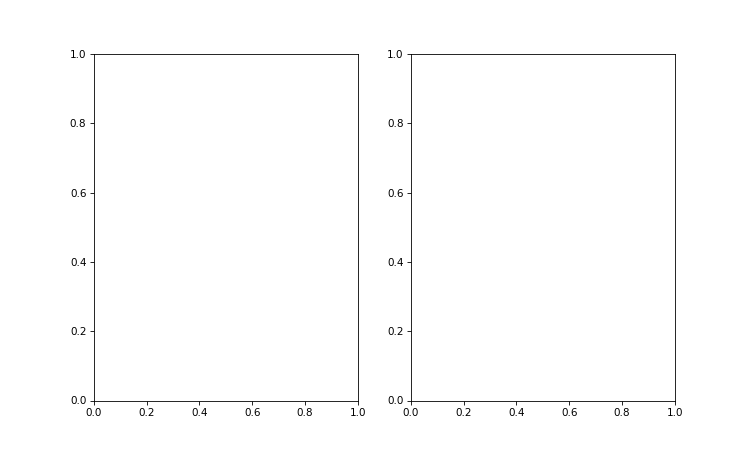

NameError: name 'ex79N6' is not defined

In [115]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(10,6))

T = 50e-3
num = -17
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0][num:]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    ax[0].plot(Is, Vs, '.', ls='-',label = '{}A'.format(si_format(ex79N6['B'][ex79N6['T']==T].tolist()[0][num:][i])))

ax[0].set_xlim(2e-8,4.5e-8)        
ax[0].set_ylim(0e-4,4.5e-4)        
ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(0.5, 0., 0.9, 1.2))
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

Bshow = 169e-6
for i,v in enumerate(ex79N6['ids'][ex79N6['T']==T].tolist()[0]):
    if (np.abs(ex79N6['B'][ex79N6['T']==T].tolist()[0][i] - Bshow)/Bshow) < 1e-3 :
        data = get_data_by_id(v)
        Is = data[0][0]['data']
        Vs = data[0][1]['data']-data[0][1]['data'][0]
        ax[1].plot(Is, Vs, '.', ls='-')
        
ax[1].set_xlim(2e-8,4.5e-8)        
ax[1].set_ylim(0e-4,4.5e-4)        
ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$V (V)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n $IV_C$ vs $B$ at ${}K$'.format(si_format(T)), pad=10)
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

<IPython.core.display.Javascript object>


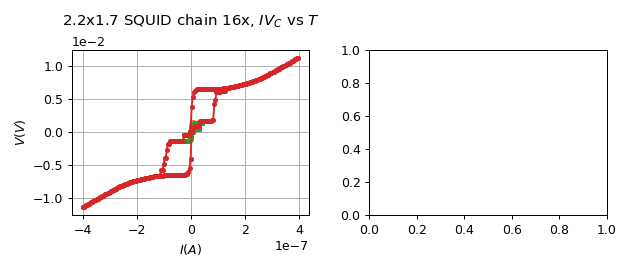

In [118]:
SAMPLE = '79N5' #6ab,7ba
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$' ,
          '$43mK$',
          '$43mK$',
          '$43mK$']
for i,v in enumerate([1,2,3,4]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('2.2x1.7 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $0.7 \times 0.2 \mu m$ junction with $E_J = 117mK, E_C = 90mK$

<IPython.core.display.Javascript object>


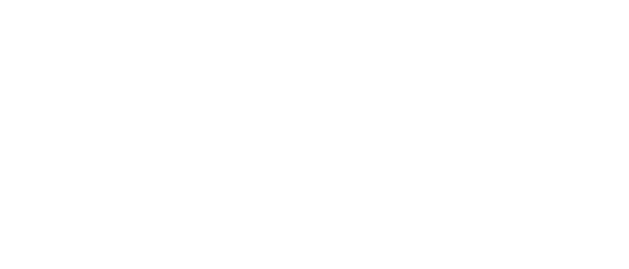

ValueError: Run with run_id 9 does not exist in the database

In [91]:
SAMPLE = '79N3' #8ab,9ab (9a is broken)
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$16K$',
          '$43mK$']
for i,v in enumerate([9,10]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('0.7x0.2 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $0.2 \times 0.2 \mu m$ junction with $E_J = 13mK, E_C = 593mK$

<IPython.core.display.Javascript object>


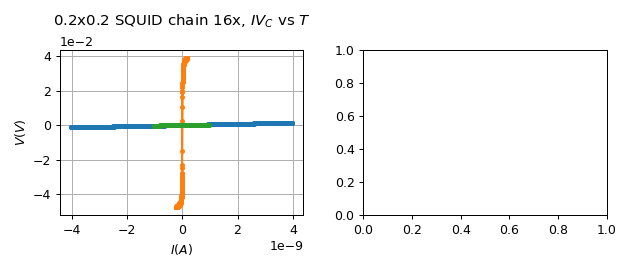

In [92]:
SAMPLE = '79N1' #11ab,12ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)
initialise_database()

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))

labelL = ['$65mK$',
          '$43mK$',
          '$16K$']
for i,v in enumerate([3,6,2]):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']
    slope, intercept, r_value, p_value, std_err = stats.linregress(Is, Vs)
    ax[0].plot(Is, Vs, '.', ls='-',label = labelL[i]+', {}$\Omega$'.format(si_format(slope)))

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$V (V)$')
ax[0].set_title('0.2x0.2 SQUID chain 16x, $IV_{C}$ vs $T$', pad=20)
# ax[0].legend()
ax[0].grid()
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

#### $1.5 \times 1.0 \mu m$ junction with $E_J = 2.8K$

## Summary